In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa as ts
import pmdarima as pm
import datetime as dt
from datetime import datetime 

## Data Prep

In [2]:
data=pd.read_csv(r"C:\Users\cnaka\Class Notes\31009 Machine Learning\Final Project\ETH-USD.csv")
vix=pd.read_csv(r"C:\Users\cnaka\Class Notes\31009 Machine Learning\Final Project\^VIX.csv")
spy=pd.read_csv(r"C:\Users\cnaka\Class Notes\31009 Machine Learning\Final Project\SPY.csv")
ten=pd.read_csv(r"C:\Users\cnaka\Class Notes\31009 Machine Learning\Final Project\^TNX.csv")
five=pd.read_csv(r"C:\Users\cnaka\Class Notes\31009 Machine Learning\Final Project\^FVX.csv")
thirty=pd.read_csv(r"C:\Users\cnaka\Class Notes\31009 Machine Learning\Final Project\^TYX.csv")
ten.columns = ["Date","Open_Ten","High_Ten","Low_Ten","Close_Ten",'Adj_Close_Ten',"Volume_Ten"]
five.columns = ["Date","Open_Five","High_Five","Low_Five","Close_Five",'Adj_Close_Five',"Volume_Five"]
thirty.columns = ["Date","Open_Thirty","High_Thirty","Low_Thirty","Close_Thirty",'Adj_Close_Thirty',"Volume_Thirty"]
spy.columns = ["Date","Open_SPY","High_SPY","Low_SPY","Close_SPY",'Adj_Close_SPY',"Volume_SPY"]
vix.columns = ["Date","Open_VIX","High_VIX","Low_VIX","Close_VIX",'Adj_Close_VIX',"Volume_VIX"]
data = data.merge(vix,on="Date").merge(spy,on="Date").merge(five,on="Date").merge(ten,on="Date").merge(thirty,on="Date")
for i in range(0,data.shape[0]):
    for j in range(0,data.shape[1]):
        if data.isnull().iloc[i,j]==True:
            data.iloc[i,j]=data.iloc[i-1,j]
data["Yield_Spread"] = data["Close_Thirty"]-data["Close_Five"]
data["MA10"] = data["Close"].shift(1).rolling(window=10).mean().fillna(0)
data["MA50"] = data["Close"].shift(1).rolling(window=50).mean().fillna(0)
data["MA200"] = data["Close"].shift(1).rolling(window=200).mean().fillna(0)
data["MACD"] = (data.Close.ewm(span=12).mean().fillna(0)-data.Close.ewm(span=26).mean().fillna(0))
data["MACD_Signal"]=data.MACD.ewm(span=9).mean().fillna(0)
data["MACD_Indicator"]=data["MACD"]-data["MACD_Signal"].fillna(0)
data["Bollinger_High"] = (data["Close"].rolling(window=20).mean()+2*data["Close"].rolling(window=20).std()).fillna(0)
data["Bollinger_Low"] = (data["Close"].rolling(window=20).mean()-2*data["Close"].rolling(window=20).std()).fillna(0)
data["Date"]=pd.to_datetime(data["Date"])
datadiff=data.diff()
datadiff["Date"]=data["Date"]
data=data.merge(datadiff[["Close","Date"]],on="Date").rename(columns={"Close_x":"Close",
            "Close_y":"Return"})
data["Return_Binary"]=[1 if data["Return"][x]>0 else 0 for x in range(0,len(data))]
data["CenMA10"]=np.zeros(len(data))
maw=10
for i in range(int(maw/2-1),len(data)-int(maw/2)):
    data.loc[i,"CenMA10"]=sum(data["Close"][i:i+maw])/maw
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Open_VIX,High_VIX,Low_VIX,...,MA50,MA200,MACD,MACD_Signal,MACD_Indicator,Bollinger_High,Bollinger_Low,Return,Return_Binary,CenMA10
1252,2020-11-16,447.558990,463.831024,445.501617,459.940308,459.940308,1.144124e+10,23.660000,24.08,22.430000,...,381.723126,278.523084,23.683894,17.797286,5.886608,483.621209,349.880345,-14.686126,0,0.0
1253,2020-11-17,464.406647,482.232208,460.776611,480.360077,480.360077,1.459306e+10,22.840000,24.09,22.340000,...,383.157109,279.873460,25.206254,19.279080,5.927174,490.984909,353.638962,20.419769,1,0.0
1254,2020-11-18,480.346832,491.999908,465.830963,479.484070,479.484070,1.788020e+10,22.860001,23.92,21.660000,...,386.012268,281.329007,26.041854,20.631635,5.410219,498.320789,355.032492,-0.876007,0,0.0
1255,2020-11-19,479.481018,480.121735,465.704254,471.630432,471.630432,1.247393e+10,23.620001,24.52,22.559999,...,388.579749,282.705276,25.773252,21.659958,4.113294,503.650783,355.488243,-7.853638,0,0.0
1256,2020-11-20,471.631470,513.610352,471.631470,509.744568,509.744568,1.862994e+10,23.430000,23.73,22.129999,...,390.650320,284.001733,28.309540,22.989874,5.319666,516.137587,352.999227,38.114136,1,0.0


Text(0.5, 0, 'MACD')

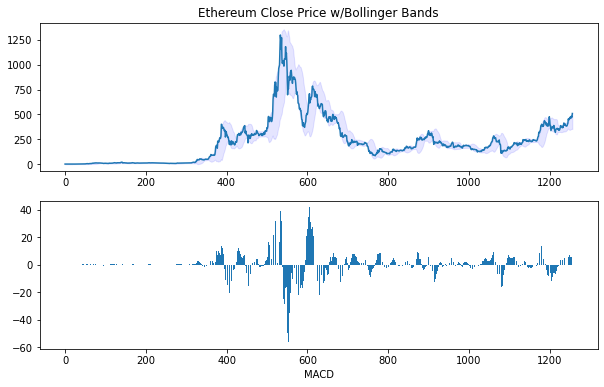

In [3]:
fig=plt.figure(figsize=(10,6))
ax1=fig.add_subplot(211)
ax1.plot(data["Close"])
ax1.fill_between(range(0,len(data)),data["Bollinger_High"],data["Bollinger_Low"], color='b', alpha=.1)
ax1.set_title("Ethereum Close Price w/Bollinger Bands")
ax2=fig.add_subplot(212)
ax2.bar(x=range(0,len(data)),height=data["MACD_Indicator"])
ax2.set_xlabel("MACD")


In [76]:
h=1 #forecast horizon
w=7 #window size

In [54]:
data=data[(data["Date"]>="2017-05-25") & (data["Date"]<="2020-11-15")]
data=data.reset_index().drop("index",axis=1)
train=data.loc[0:round(len(data["Return"])*.6)][["Close","Volume","MACD_Indicator"#,"Open","High","Low","Volume","CenMA10"#,"Close_VIX","Volume","MA10","MA50","MA200","MACD_Indicator","Bollinger_High","Bollinger_Low"
                                               ]]
validate = data.loc[round(len(data["Return"])*.6)+1:round(len(data["Return"])*.8)][["Close","Volume","MACD_Indicator"#,"Open","High","Low","Volume","CenMA10"#,"Close_VIX","Volume"#,"MA10","MA50","MA200","MACD_Indicator","Bollinger_High","Bollinger_Low"
                                                                                 ]]
test =data.loc[round(len(data["Return"])*.8)+1:][["Close","Volume","MACD_Indicator"#,"Open","High","Low","Volume","CenMA10"#,"Close_VIX","Volume"#,"MA10","MA50","MA200","MACD_Indicator","Bollinger_High","Bollinger_Low"
                                                ]]

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled=scaler.fit_transform(train)
validate_scaled=scaler.transform(validate)
test_scaled=scaler.transform(test)

In [77]:
def create_datasets(X,w,h):
    X_set,Y_set=[],[]
    for i in range(w,len(X)):
        X_set.append(X[i-w:i,])
        Y_set.append(X[i:i+h,0]#.reshape((w,1))
                    )
    return np.array(X_set),np.array(Y_set)

In [78]:
X_train,Y_train=create_datasets(train_scaled,w,h)
X_validate,Y_validate=create_datasets(validate_scaled,w,h)
X_test,Y_test=create_datasets(test_scaled,w,h)
print(X_train.shape,Y_train.shape)
print(X_validate.shape,Y_validate.shape)
print(X_test.shape,Y_test.shape)

(520, 7, 3) (520, 1)
(168, 7, 3) (168, 1)
(167, 7, 3) (167, 1)


# Linear Regression

In [84]:
from sklearn.linear_model import LinearRegression
y=data[data["Date"]>"2017-05-23"]["Close"].diff()[1:]
X=datadiff[datadiff["Date"]>"2017-05-24"].drop("Date",axis=1)[["Close","Volume","Close_VIX","Volume_VIX","Close_SPY","Volume_SPY","Close_Five","Close_Ten","Close_Thirty","Yield_Spread"]][:-1].fillna(0)
lm=LinearRegression()
lm.fit(y=y,X=X)
lm.score(y=y,X=X)

0.04365965886935641

# Time Series

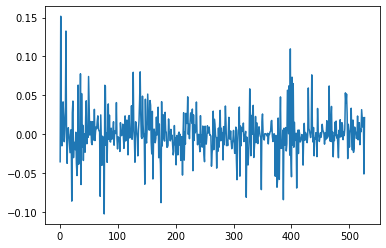

In [105]:
from scipy.stats import boxcox
plt.plot(pd.DataFrame(boxcox(train["Close"])[0]).diff())
dataadj=boxcox(train["Close"])[0]

In [106]:
pm.auto_arima(dataadj, start_p=1, start_q=1,
                         test='adf',
                         start_P=0, 
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2299.176, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2302.538, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2301.169, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2301.181, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2304.399, Time=0.08 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.812 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

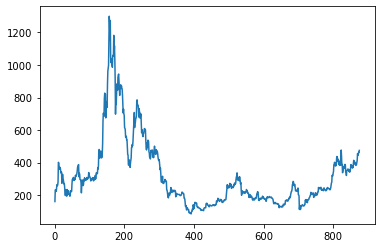

In [107]:
plt.plot(data[data["Date"]>"2017-05-25"]["Close"])

In [109]:
pm.auto_arima(train[data["Date"]>"2017-05-25"]["Close"],start_p=1, start_q=1,
                         test='adf',
                         start_P=0, 
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

<ipython-input-109-75ff775b6d4c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pm.auto_arima(train[data["Date"]>"2017-05-25"]["Close"],start_p=1, start_q=1,


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5172.369, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5169.263, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5171.248, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5171.249, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5167.303, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.673 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [111]:
arimax=pm.auto_arima(data[data["Date"]>"2017-05-24"]["Close"].diff()[1:],exongenous=datadiff[datadiff["Date"]>="2017-05-25"],start_p=1, start_q=1,
                         test='adf',
                         start_P=0, 
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True,
                         information_criterion="aicc",
                         stepwise=True)


Performing stepwise search to minimize aicc
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AICC=8257.935, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AICC=8255.118, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AICC=8257.127, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AICC=8257.127, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AICC=8253.250, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.776 seconds


In [48]:
arimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  880
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -3038.384
Date:                Tue, 24 Nov 2020   AIC                           6080.768
Time:                        15:58:07   BIC                           6090.328
Sample:                             0   HQIC                          6084.424
                                - 880                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2042      0.009     22.345      0.000       0.186       0.222
sigma2        58.4098      0.737     79.298      0.000      56.966      59.854
===================================================================================
Ljung-Box (Q):                      124.60   Jarque-Bera (JB):             72243.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             2.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        47.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [76]:
max(data["Date"])

'2020-11-20'

In [54]:
datadiff.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Open_VIX',
       'High_VIX', 'Low_VIX', 'Close_VIX', 'Adj_Close_VIX', 'Volume_VIX',
       'Open_SPY', 'High_SPY', 'Low_SPY', 'Close_SPY', 'Adj_Close_SPY',
       'Volume_SPY', 'Open_Five', 'High_Five', 'Low_Five', 'Close_Five',
       'Adj_Close_Five', 'Volume_Five', 'Open_Ten', 'High_Ten', 'Low_Ten',
       'Close_Ten', 'Adj_Close_Ten', 'Volume_Ten', 'Open_Thirty',
       'High_Thirty', 'Low_Thirty', 'Close_Thirty', 'Adj_Close_Thirty',
       'Volume_Thirty', 'Yield_Spread', 'Date'],
      dtype='object')

# Neural Nets

## Naive Forecast

In [11]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_addons as tfa
tf.config.run_functions_eagerly(True)

In [102]:
itr=len(Y_train-h)
errors=[]
for i in range(1,itr):
    errors.append((Y_train[i]-Y_train[i-1])**2)
print("MSE={}".format(sum(errors)/(len(Y_train)-1)))

MSE=[0.01942502]


## Basic LSTM

In [112]:
model=keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True,input_shape = [X_train.shape[1],X_train.shape[2]]),
    keras.layers.Dropout(.3),
    keras.layers.LSTM(40,return_sequences=True),
    keras.layers.LSTM(20),
    keras.layers.Dense(1)
])
model.compile(loss="MeanSquaredError",optimizer = "adam")
model.fit(x=X_train,y=Y_train,epochs=50)

Epoch 1/50
 3/17 [====>.........................] - ETA: 0s - loss: 0.9218

C:\Users\cnaka\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


17/17 [==============================] - 1s 39ms/step - loss: 0.6589
Epoch 2/50
17/17 [==============================] - 1s 38ms/step - loss: 0.2269
Epoch 3/50
17/17 [==============================] - 1s 39ms/step - loss: 0.1518
Epoch 4/50
17/17 [==============================] - 1s 37ms/step - loss: 0.1093
Epoch 5/50
17/17 [==============================] - 1s 40ms/step - loss: 0.0638
Epoch 6/50
17/17 [==============================] - 1s 35ms/step - loss: 0.0512
Epoch 7/50
17/17 [==============================] - 1s 40ms/step - loss: 0.0509
Epoch 8/50
17/17 [==============================] - 1s 39ms/step - loss: 0.0419
Epoch 9/50
17/17 [==============================] - 1s 36ms/step - loss: 0.0428
Epoch 10/50
17/17 [==============================] - 1s 37ms/step - loss: 0.0382
Epoch 11/50
17/17 [==============================] - 1s 39ms/step - loss: 0.0374
Epoch 12/50
17/17 [==============================] - 1s 37ms/step - loss: 0.0368
Epoch 13/50
17/17 [=============================

In [113]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 10, 20)            2160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 20)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 10, 40)            9760      
_________________________________________________________________
lstm_9 (LSTM)                (None, 20)                4880      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 21        
Total params: 16,821
Trainable params: 16,821
Non-trainable params: 0
_________________________________________________________________


In [114]:
model.evaluate(x=X_validate,y=Y_validate)

6/6 [==============================] - 0s 22ms/step - loss: 0.0259


0.025903921574354172

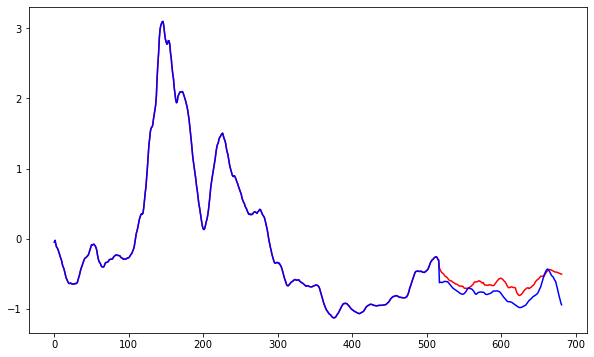

In [115]:
plt.figure(figsize=(10,6))
plt.plot(np.vstack((Y_train,model.predict(X_validate))),color="red")
plt.plot(np.vstack((Y_train,Y_validate)),color="blue")

## GRU Cells

In [79]:

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model = keras.models.Sequential([
    #keras.layers.Conv1D(filters=50,kernel_size=3,strides=1,padding="valid",input_shape = [X_train.shape[1],X_train.shape[2]]),
    keras.layers.GRU(50,return_sequences=True,recurrent_dropout=.1),
    keras.layers.GRU(50,recurrent_dropout=.1),
    keras.layers.Dense(1)
])
opt = keras.optimizers.Adam(learning_rate=.001)
model.compile(optimizer=opt,loss=sign_loss_wrapper(1.05))
model.fit(X_train,Y_train,epochs=100,validation_data=(X_test,Y_test),callbacks=[callback]
         )

C:\Users\cnaka\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/100
17/17 [==============================] - 2s 105ms/step - loss: 0.5191 - val_loss: 0.1194
Epoch 2/100
17/17 [==============================] - 1s 81ms/step - loss: 0.0799 - val_loss: 0.1922
Epoch 3/100
17/17 [==============================] - 1s 82ms/step - loss: 0.0494 - val_loss: 0.0300
Epoch 4/100
17/17 [==============================] - 1s 81ms/step - loss: 0.0407 - val_loss: 0.0360
Epoch 5/100
17/17 [==============================] - 1s 79ms/step - loss: 0.0381 - val_loss: 0.0155
Epoch 6/100
17/17 [==============================] - 1s 80ms/step - loss: 0.0338 - val_loss: 0.0126
Epoch 7/100
17/17 [==============================] - 1s 81ms/step - loss: 0.0304 - val_loss: 0.0137
Epoch 8/100
17/17 [==============================] - 1s 81ms/step - loss: 0.0316 - val_loss: 0.0100
Epoch 9/100
17/17 [==============================] - 1s 82ms/step - loss: 0.0315 - val_loss: 0.0109
Epoch 10/100
17/17 [==============================] - 1s 80ms/step - loss: 0.0288 - val_loss: 0.008

In [80]:
model.evaluate(X_test,Y_test)

6/6 [==============================] - 0s 29ms/step - loss: 0.0071


0.007056738715618849

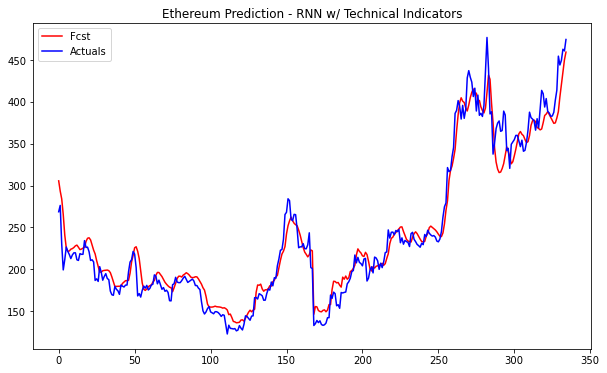

In [81]:
plt.figure(figsize=(10,6))
plt.plot(np.vstack((np.sqrt(scaler.var_[0])*model.predict(X_validate)+scaler.mean_[0],np.sqrt(scaler.var_[0])*model.predict(X_test)+scaler.mean_[0])),color="red",label="Fcst")
plt.plot(np.vstack((np.sqrt(scaler.var_[0])*Y_validate+scaler.mean_[0],np.sqrt(scaler.var_[0])*Y_test+scaler.mean_[0])),color="blue",label="Actuals")
plt.title("Ethereum Prediction - RNN w/ Technical Indicators")
plt.legend()

In [82]:
df=pd.DataFrame()
df["Forecast"]=(np.sqrt(scaler.var_[0])*model.predict(X_test).T+scaler.mean_[0]).flatten()
df["Actual"]=(np.sqrt(scaler.var_[0])*Y_test.T+scaler.mean_[0]).flatten()
df

C:\Users\cnaka\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


,Forecast,Actual
0,146.224518,132.737167
1,155.360962,134.911606
2,155.092575,138.761444
3,150.675720,136.195892
4,149.464203,138.361557
...,...,...
162,406.039062,444.163055
163,420.602417,449.679626
164,435.696106,462.960541
165,450.293945,461.005280


In [83]:
df["Predicted Move"]=np.zeros(167)
df["Correct Sign"]=np.zeros(167)
for i in range(1,len(df["Forecast"])):
    df.iloc[i,2]=(np.sign(df["Forecast"][i]-df["Actual"][i-1])==1)
    if np.sign(df["Forecast"][i]-df["Actual"][i-1])==np.sign(df["Actual"][i]-df["Actual"][i-1]):
        df.iloc[i,3]=1
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)


       Forecast      Actual Predicted Move  Correct Sign
0    146.224518  132.737167              0           0.0
1    155.360962  134.911606           True           1.0
2    155.092575  138.761444           True           1.0
3    150.675720  136.195892           True           0.0
4    149.464203  138.361557           True           1.0
5    149.075378  133.937943           True           0.0
6    150.857346  132.904541           True           0.0
7    151.419113  133.593567           True           1.0
8    149.154602  135.634552           True           1.0
9    151.173523  142.029144           True           1.0
10   157.668655  142.091309           True           1.0
11   157.801102  169.135880           True           1.0
12   175.604965  165.101944           True           0.0
13   185.621536  172.641739           True           1.0
14   185.358627  170.807144           True           0.0
15   183.653214  156.279556           True           0.0
16   184.173904  157.596390    

In [88]:
print("DPA={}".format(round(sum(df["Correct Sign"])/len(df["Correct Sign"]),2)))

DPA=0.54


## Custom Loss Function

In [69]:
def sign_loss_wrapper(alpha):
    def sign_loss(y_true, y_pred):
        #extract the "next day's price" of tensor
        y_true_next = y_true[1:]
        y_pred_next = y_pred[1:]
        #extract the "today's price" of tensor
        y_true_tdy = y_true[:-1]
        y_pred_tdy = y_pred[:-1]
        #substract to get up/down movement of the two tensors
        y_true_diff = tf.reshape(tf.subtract(y_true_next, y_true_tdy),[-1])
        y_pred_diff = tf.reshape(tf.subtract(y_pred_next, y_true_tdy),[-1])
        #create a standard tensor with zero value for comparison
        standard = tf.zeros_like(y_pred_diff)
        #compare with the standard; if true, UP; else DOWN
        y_true_move = tf.greater_equal(y_true_diff, standard)
        y_pred_move = tf.greater_equal(y_pred_diff, standard)
        #find indices where the directions are not the same
        condition = (tf.not_equal(y_true_move, y_pred_move)&y_true_move==False)
        indices =tf.where(condition)
        ones = tf.ones_like(indices)
        indices = tf.add(indices, ones)
        direction_loss = tf.Variable(tf.ones_like(y_pred), dtype='float32')
        updates = keras.backend.cast(tf.ones_like(indices),dtype='float32')
        direction_loss = tf.tensor_scatter_nd_update(direction_loss, indices, alpha*updates)
        return keras.backend.mean(tf.multiply(keras.backend.square(y_true - y_pred), direction_loss), axis=-1)
    return sign_loss

In [65]:
def sign_loss_diffed(alpha):
    def internal(y_true,y_pred):
        standard = tf.zeros_like(y_pred)
        y_true_move = tf.reshape(tf.greater_equal(y_true, standard),[-1])
        y_pred_move = tf.reshape(tf.greater_equal(y_pred, standard),[-1])
        condition = tf.not_equal(y_true_move, y_pred_move)
        indices =tf.where(condition)
        direction_loss = tf.Variable(tf.ones_like(y_pred), dtype='float32')
        updates = keras.backend.cast(tf.ones_like(indices),dtype='float32')
        direction_loss = tf.tensor_scatter_nd_update(direction_loss, indices, alpha*updates)
        return keras.backend.mean(tf.multiply(keras.backend.square(y_true - y_pred), direction_loss), axis=-1)
    return internal

In [41]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20,kernel_size=5,padding="valid",input_shape = [X_train.shape[1],X_train.shape[2]]),
    keras.layers.GRU(200,return_sequences=True,input_shape = [X_train.shape[1],X_train.shape[2]]),
    keras.layers.Dropout(.3),
    keras.layers.GRU(200),
    #keras.layers.Dropout(.2),
    #keras.layers.GRU(50,return_sequences=True),
    keras.layers.Dense(1)
])
model.compile(optimizer="adam",loss=sign_loss_wrapper(1.15))
model.fit(x=X_train,y=Y_train,epochs=1)

Epoch 1/10
14/14 [==============================] - 6s 461ms/step - loss: 0.2211
Epoch 2/10
14/14 [==============================] - 6s 454ms/step - loss: 0.0692
Epoch 3/10
14/14 [==============================] - 6s 449ms/step - loss: 0.0539
Epoch 4/10
14/14 [==============================] - 7s 474ms/step - loss: 0.0484
Epoch 5/10
14/14 [==============================] - 7s 469ms/step - loss: 0.0443
Epoch 6/10
14/14 [==============================] - 6s 457ms/step - loss: 0.0425
Epoch 7/10
14/14 [==============================] - 6s 458ms/step - loss: 0.0390
Epoch 8/10
14/14 [==============================] - 7s 466ms/step - loss: 0.0368
Epoch 9/10
14/14 [==============================] - 8s 565ms/step - loss: 0.0353
Epoch 10/10
14/14 [==============================] - 8s 577ms/step - loss: 0.0336


In [99]:
model.evaluate(x=X_validate,y=Y_validate)

3/3 [==============================] - 0s 138ms/step - loss: 0.0038


0.003836629446595907

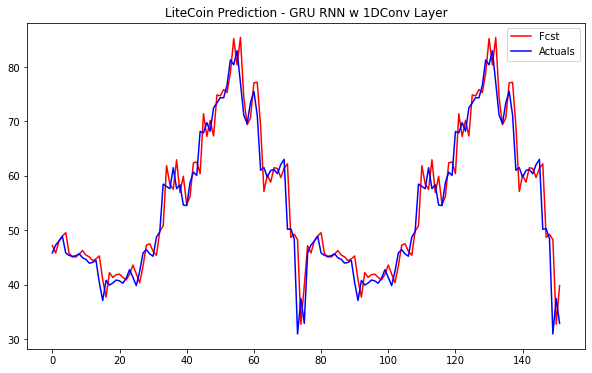

In [100]:
plt.figure(figsize=(10,6))
plt.plot(np.vstack((np.sqrt(scaler.var_)*model.predict(X_validate)+scaler.mean_,np.sqrt(scaler.var_)*model.predict(X_test)+scaler.mean_)),color="red",label="Fcst")
plt.plot(np.vstack((np.sqrt(scaler.var_)*Y_validate+scaler.mean_,np.sqrt(scaler.var_)*Y_test+scaler.mean_)),color="blue",label="Actuals")
plt.title("LiteCoin Prediction - GRU RNN w 1DConv Layer")
plt.legend()

In [101]:
df=pd.DataFrame()
df["Forecast"]=(np.sqrt(scaler.var_)*model.predict(X_validate).T+scaler.mean_).flatten()
df["Actual"]=(np.sqrt(scaler.var_)*Y_validate.T+scaler.mean_).flatten()
df["Correct Sign"]=np.zeros(76)
for i in range(1,len(df["Forecast"])):
    if np.sign(df["Forecast"][i]-df["Actual"][i-1])==np.sign(df["Actual"][i]-df["Actual"][i-1]):
        df.iloc[i,2]=1
sum(df["Correct Sign"])/len(df["Correct Sign"])

C:\Users\cnaka\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.47368421052631576

## GAN

In [154]:

G = keras.models.Sequential([
    keras.layers.GRU(200,return_sequences=True,input_shape = [w,1]),
    keras.layers.Dropout(.3),
    keras.layers.GRU(200,return_sequences=True),
    #keras.layers.Dropout(.2),
    #keras.layers.GRU(50,return_sequences=True),
    keras.layers.Dense(1)
])
#G.compile(optimizer="adam",loss="mse")
G.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_34 (GRU)                 (None, 100, 200)          121800    
_________________________________________________________________
dropout_22 (Dropout)         (None, 100, 200)          0         
_________________________________________________________________
gru_35 (GRU)                 (None, 100, 200)          241200    
_________________________________________________________________
dense_22 (Dense)             (None, 100, 1)            201       
Total params: 363,201
Trainable params: 363,201
Non-trainable params: 0
_________________________________________________________________


In [137]:
G.fit(x=X_train,y=Y_train,epochs=10)

C:\Users\cnaka\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/10
15/15 [==============================] - 10s 673ms/step - loss: 0.4194
Epoch 2/10
15/15 [==============================] - 10s 657ms/step - loss: 0.2305
Epoch 3/10
15/15 [==============================] - 10s 664ms/step - loss: 0.1992
Epoch 4/10
15/15 [==============================] - 10s 665ms/step - loss: 0.1845
Epoch 5/10
15/15 [==============================] - 10s 667ms/step - loss: 0.1787
Epoch 6/10
15/15 [==============================] - 10s 672ms/step - loss: 0.1749
Epoch 7/10
15/15 [==============================] - 10s 665ms/step - loss: 0.1705
Epoch 8/10
15/15 [==============================] - 10s 658ms/step - loss: 0.1673
Epoch 9/10
15/15 [==============================] - 10s 670ms/step - loss: 0.1621
Epoch 10/10
15/15 [==============================] - 10s 655ms/step - loss: 0.1593


In [155]:
D = keras.models.Sequential([
    keras.layers.Conv1D(32,4,strides=2,input_shape=[w,1]),
    keras.layers.LeakyReLU(),
    keras.layers.Conv1D(64,4,strides=2),
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(128,4,strides=2),
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    #keras.layers.Flatten(),
    keras.layers.Dropout(.3),
    keras.layers.Dense(1,activation='tanh')
])
D.compile(optimizer="adam",loss="binary_crossentropy")
D.summary()


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 49, 32)            160       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 49, 32)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 23, 64)            8256      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 23, 64)            0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 23, 64)            256       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 10, 128)           32896     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 10, 128)         

In [156]:
D.trainable=False
gan_input = keras.Input(shape=[w,1])
gan_output = D(G(gan_input))
gan=keras.models.Model(gan_input,gan_output)
gan_optimizer = keras.optimizers.RMSprop(lr=.0004,clipvalue=1,decay=1e-8)
gan.compile(optimizer=gan_optimizer,loss='binary_crossentropy')

In [157]:
iterations=100
batchsize=14
start=0
random_latent_vectors=np.random.normal(size=(batchsize,w,1))
for step in range(iterations):
    generated_sequences = G.predict(random_latent_vectors)
    stop = start+batchsize
    real_sequences = X_train[start:stop]
    combined_sequences = np.concatenate([generated_sequences,real_sequences])
    labels = np.concatenate([np.zeros((batchsize,1)),np.ones((batchsize,1))])
    labels += .05*np.random.random(labels.shape)
    D_loss=D.train_on_batch(combined_sequences,labels)
    random_latent_vectors=np.random.normal(size=(batchsize,w,1))
    misleading_labels = np.zeros((batchsize,1))
    a_loss=gan.train_on_batch(random_latent_vectors,misleading_labels)
    start=start+batchsize
    if start>len(X_train)-batchsize:
        start=0
    if step%50==0:
        print("Discriminator Loss=",D_loss)
        print("Adverserial Loss=",a_loss)

C:\Users\cnaka\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Discriminator Loss= 0.6948157548904419
Adverserial Loss= 0.018529895693063736
Discriminator Loss= 0.14166761934757233
Adverserial Loss= 0.4475536346435547


In [87]:
df=pd.DataFrame()
df["Forecast"]=(np.sqrt(scaler.var_)*G.predict(X_validate)[:,-1]+scaler.mean_).flatten()
df["Actual"]=(np.sqrt(scaler.var_)*Y_validate[:,-1].reshape((76,1))+scaler.mean_).flatten()
df["Correct Sign"]=np.zeros(76)
for i in range(1,len(df["Forecast"])):
    if np.sign(df["Forecast"][i]-df["Actual"][i-1])==np.sign(df["Actual"][i]-df["Actual"][i-1]):
        df.iloc[i,2]=1
sum(df["Correct Sign"])/len(df["Correct Sign"])

C:\Users\cnaka\anaconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3349: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.5131578947368421

In [111]:
train_scaled[0:60,0].shape

(60,)

## Classification Model

In [110]:
data["Date"]=pd.to_datetime(data["Date"])
datadiff=data.diff()
datadiff["Date"]=data["Date"]
data=data.merge(datadiff[["Close","Date"]],on="Date").rename(columns={"Close_x":"Close",
            "Close_y":"Return"})
data["Return_Binary"]=[1 if data["Return"][x]>0 else 0 for x in range(0,len(data))]
data.tail()

In [99]:
data=data[data["Date"]>="2015-11-24"]
data=data.reset_index().drop("index",axis=1)
train=data.loc[0:round(len(data["Close"])*.6)][["Return","Volume","MA10","MA50","MA200","MACD_Indicator","Return_Binary"#,"Volume","Bollinger_High","Bollinger_Low"
                                               ]]
validate = data.loc[round(len(data["Close"])*.6)+1:round(len(data["Close"])*.8)][["Return","Volume","MA10","MA50","MA200","MACD_Indicator","Return_Binary"#,"Volume","Bollinger_High","Bollinger_Low"
                                                                                 ]]
test =data.loc[round(len(data["Close"])*.8)+1:][["Return","Volume","MA10","MA50","MA200","MACD_Indicator","Return_Binary"#,"Volume","Bollinger_High","Bollinger_Low"
                                                ]]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_scaled=scaler.fit_transform(train)
validate_scaled=scaler.transform(validate)
test_scaled=scaler.transform(test)
def create_datasets2(X,Y,w,h):
    X_set,Y_set=[],[]
    for i in range(w,len(X)):
        X_set.append(X[i-w:i,])
        Y_set.append(Y[i:i+h,].values[0]#.reshape((w,1))
                    )
    return np.array(X_set),np.array(Y_set)
X_train,Y_train=create_datasets2(train_scaled[:,0:6],train["Return_Binary"],w,h)
X_validate,Y_validate=create_datasets2(validate_scaled[:,0:6],validate["Return_Binary"],w,h)
X_test,Y_test=create_datasets2(test_scaled[:,0:6],test["Return_Binary"],w,h)
X_train=X_train.reshape((X_train.shape[0],X_train.shape[1],X_validate.shape[2]))
X_validate=X_validate.reshape((X_validate.shape[0],X_validate.shape[1],X_validate.shape[2]))
X_test=X_test.reshape((X_test.shape[0],X_test.shape[1],X_validate.shape[2]))
print(X_train.shape,Y_train.shape)
print(X_validate.shape,Y_validate.shape)
print(X_test.shape,Y_test.shape)

(655, 100, 6) (655,)
(151, 100, 6) (151,)
(150, 100, 6) (150,)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model=keras.models.Sequential([
    keras.layers.Conv1D(filters=20,kernel_size=5,padding="valid",input_shape = [X_train.shape[1],X_train.shape[2]]),
    keras.layers.RNN(tfa.rnn.LayerNormLSTMCell(units=50,recurrent_dropout=.1),return_sequences=True),
    keras.layers.RNN(tfa.rnn.LayerNormLSTMCell(units=50,recurrent_dropout=.1)),
    keras.layers.Dense(1,activation="sigmoid")
])
model.compile(loss="binary_crossentropy",optimizer = "adam",metrics=["accuracy"])
model.fit(x=X_train,y=Y_train,epochs=100,validation_data=(X_validate,Y_validate),#callbacks=[callback]
         )

In [ ]:
model.evaluate(X_test,Y_test)

In [ ]:
pd.DataFrame([model.predict(X_test).flatten().T,Y_test.flatten().T])

In [ ]:
model.summary()